<a href="https://colab.research.google.com/github/manusmriti31/Learning_PyTorch/blob/main/Video%20notebooks/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [2]:
# Setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get data

> Our dataset is a subset of the Food101 datset.
>
> Food101 starts 101 different classes of food and 1000 images per class(750 for training and 250 for testing).
>
>Our dataset starts with 3 classes of food and only 10% of the images(75 for training and 25 for testing).

When starting out ML projects, it's important to try things on a small scale and then increast the scale when necessary.
The whole point is to speed up how fast you can experiment.


In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to add a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder dosen't exist, download it and prepare it....
if image_path.is_dir():
  print(f"{image_path} directory alredy exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [8]:
image_path

PosixPath('data/pizza_steak_sushi')

Random Image path: data/pizza_steak_sushi/train/pizza/3109486.jpg
Image class: pizza
Image height: 512
Image width: 512


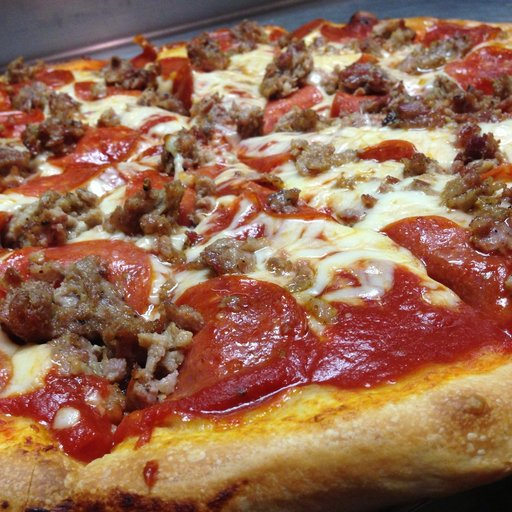

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

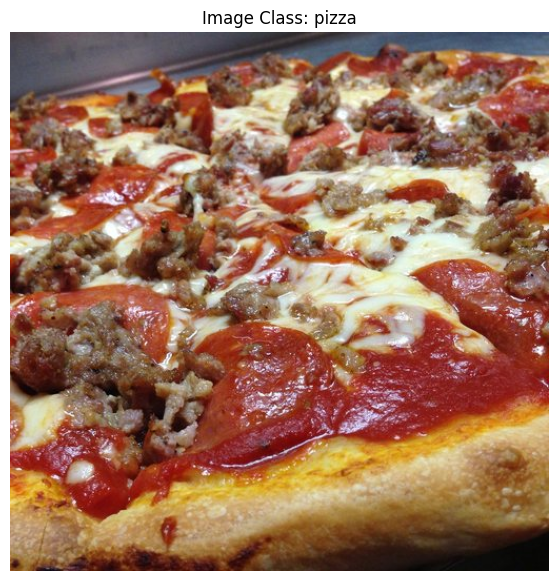

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class}")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors(in our case, numerical representation of our images.)
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader `, we'll call these `Dataset` and `DataLoader`.


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images t 64x64
    transforms.Resize(size = (64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

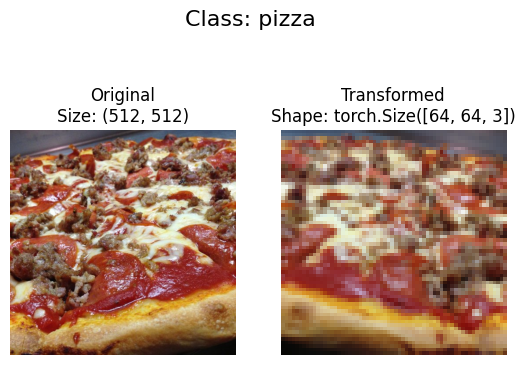

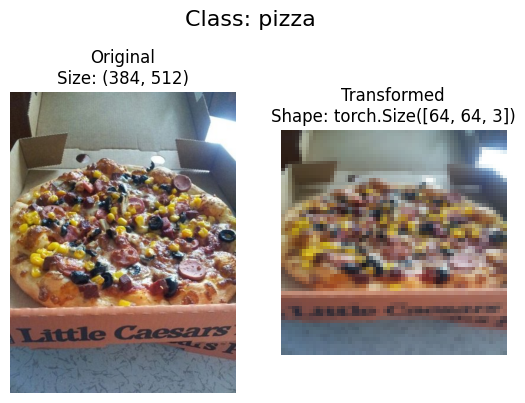

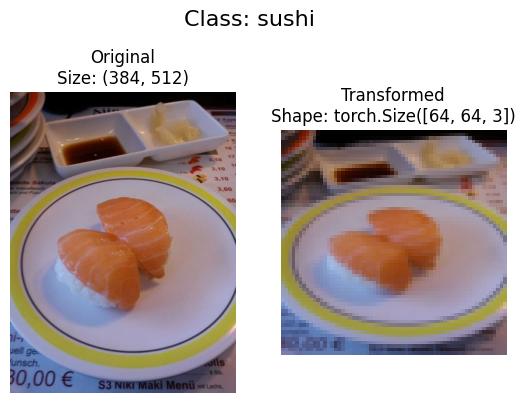

In [14]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
  """Selects random images from a paht of inmages and loads/transforms them then plots the original vs the transformed version."""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list, data_transform, 3, 42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [20]:
# Index on the train_data Dataset to get a singe image label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

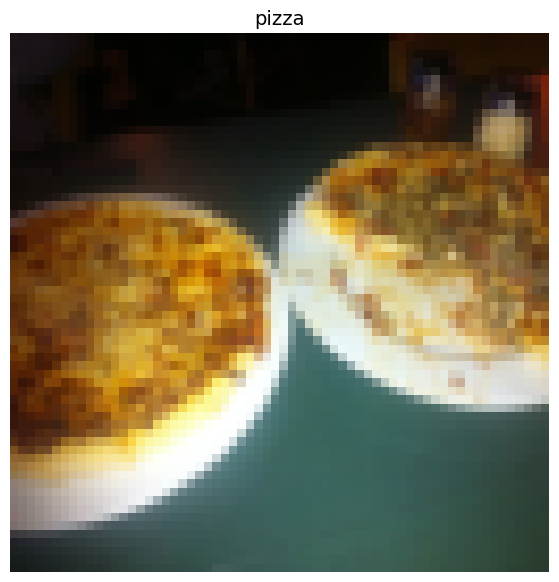

In [21]:
# Rearrange the order dimension
img_permute = img.permute(1,2,0)

# Print out differnet shapes
print(f"Original Shape: {img.shape}")
print(f"Image permute: {img_permute.shape}")

#plot the image
plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14)

### 4.1 Turn loaded images into `DataLoader's`

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the  `batch_size` so our model can see `batch_size` imgaes at a time

In [22]:
import os
os.cpu_count()

2

In [23]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x793abc8a7a60>,
 <torch.utils.data.dataloader.DataLoader at 0x793abc8a6920>)

In [24]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## 5 Option 2: loading Image Data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create `Dataset` out of almost anything
* Not limited to PyTorch pre-build `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it dosen't mean it will work...
* Using a custom `Dataset` ofent results in us writing code, which could be prone to erros or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# Instance of torchvision.dataset.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

we want a function to:
1. Get the class names using os.scandir() to traverse a target directory(ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them

In [28]:
target_directory = train_dir
print(f"Target dirr: {target_directory}")

Target dirr: data/pizza_steak_sushi/train


In [29]:
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""

  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise and error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictonary fo index labels
  class_to_idx = {class_names: i for i, class_names in enumerate(classes)}

  return classes, class_to_idx

In [30]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFOlder`

to create our own custom dataset, we want to:
1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directorcy (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Creat several attributes:
- Paths - paths of our images
- Transform - the transform we'd like to use
- classes - a litst of the target classes
- class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. OVerwrite the `__getitem()__` method to return a given


In [31]:
# 0. Write a custon dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.tils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform = None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup the transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_images(self, index: int) -> Image.Image:
    "Opnes and image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Return the total number of sample"
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X,y)"
    img = self.load_images(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [32]:
# Create a tranform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCustoms
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

### 5.3 Create a function to display random images

1. Take a  `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target data5. Setup ta mathplotlib plot.
6. Loop through the random sample indexes and plot them with mathplotlib
7. Make sure the dimensions of our images line up with mathplotlib (HWC)

In [34]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes setting the value of n to 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample index
  random_sample_idx = random.sample(range(len(dataset)),  k = n)

  # 5. Setup plot
  plt.figure(figsize = (16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjusted = targ_image.permute(1,2,0)

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjusted)
    plt.axis(False)
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjusted.shape}"
    plt.title(title)

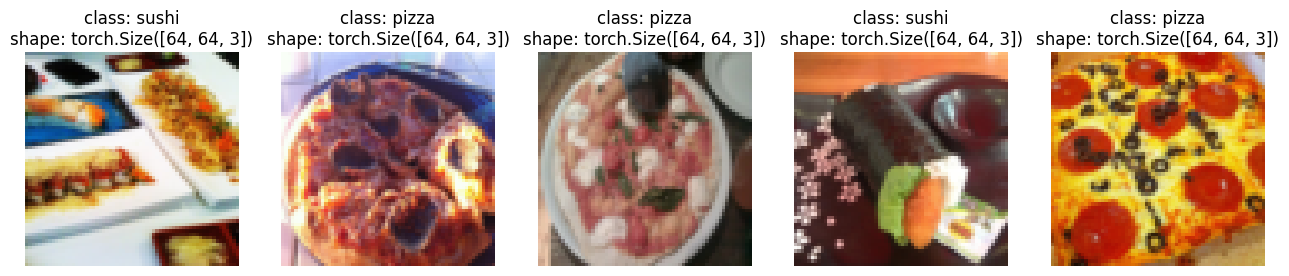

In [35]:
display_random_images(train_data,class_names, 5, seed = 42)

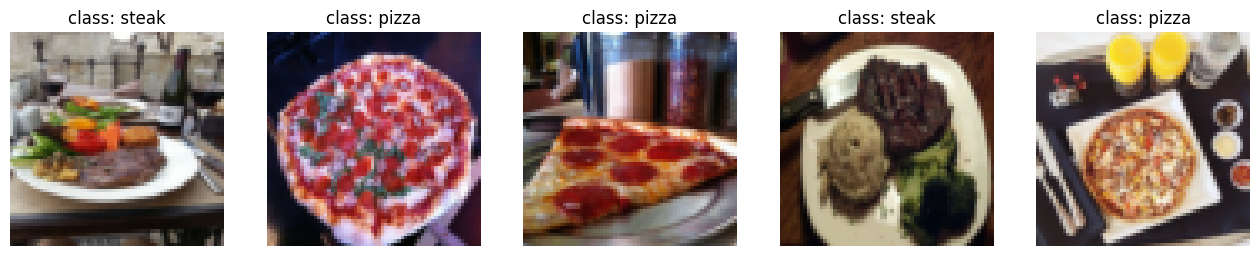

In [36]:
display_random_images(train_data_custom,class_names, 5, False, 42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [37]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x793a2510e3e0>,
 <torch.utils.data.dataloader.DataLoader at 0x793a2510ddb0>)

In [38]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.
In the case of image data, this may mean applyong various imae transformation to the training images.
This practive hopeflly results in a model that's more generatlizable to unseen data.
Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...
Let's take a look at one particlar type of data augmentaion used to train PyTorch vision mdoels to stae of the art levels

In [39]:
# Let's take a look at trivilaugment- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide
from torchvision import disable_beta_transforms_warning

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_tranform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [40]:
image_path

PosixPath('data/pizza_steak_sushi')

In [41]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/3821701.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/320570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/218711.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1654444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2451169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2702825.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3338774.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2154394.jpg')]

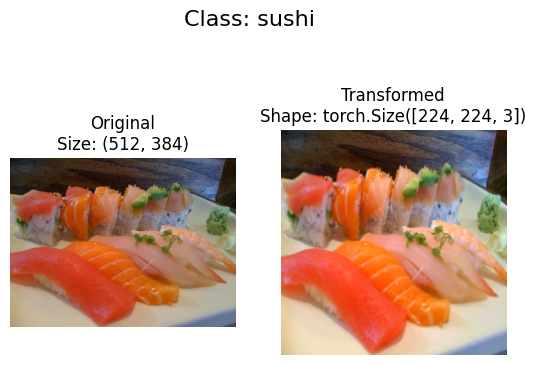

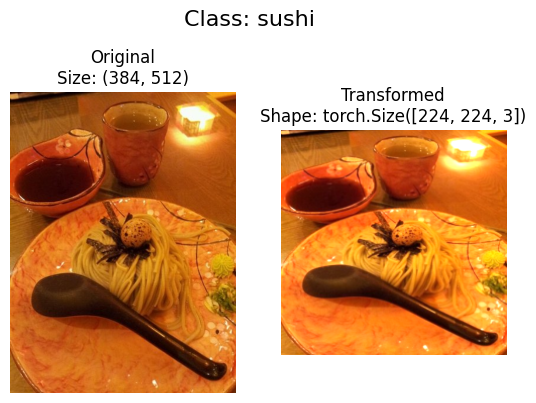

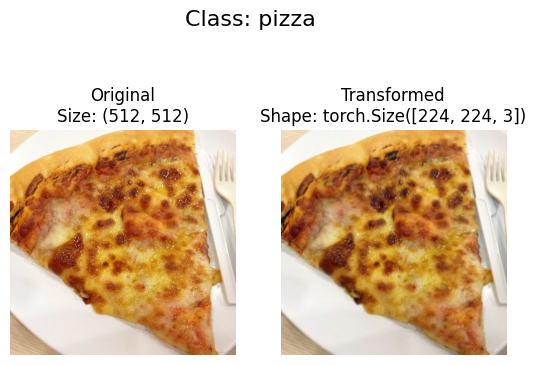

In [42]:
# Plot random transformed images
plot_transformed_images(image_path_list,train_transform,n = 3)

## 7. Model 0: TimyVGG without data augmentation


### 7.1 Creating transforms and loading data for Model 0

In [43]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [44]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)


### 7.2 Create a TinyVGG model class

In [45]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 0),
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2,
                   stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 0),
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2,
                   stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self,x):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [46]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels in our image
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [47]:
# Get a single image barch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [48]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our modelm

In [49]:
# Install torchinfo, import if available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loops functions

- `train_step()` - takes ina model and dataloader and trains the model on the dataloader.
- `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [50]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: device):
  # Put the model in train mode
  model.train()

  # Setup train loass and train accuracy values
  train_loss, train_acc = 0,0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send the data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # gives out the raw logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate the accuracy matrix
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [51]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # Put the model in eval mode
  model.eval()

  # Setup test loass and test accuracy values
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through Dataloader batchs
    for batch, (X,y) in enumerate(dataloader):
      # Send the data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = torch.argmax(test_pred_logits, dim = 1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [52]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # 2. Create empty results dictionary
  results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

  # 3. Loop through training and testing steps for number of epoch
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
    test_loss, test_acc = test_step(model = model, dataloader = test_dataloader, loss_fn = loss_fn, device = device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc* 100:.2f}% | Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%")

    # 5. Updata results dictionary
    results["test_acc"].append(test_acc)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["train_loss"].append(train_loss)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0


In [53]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Recreate and instance of TinyVGG
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train mode 0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer= optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End the timer and print out how long it took
end_timer = timer()
print(f"Total Training time: {end_timer - start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.106 | Train acc: 30.47% | Test loss: 1.098 | Test acc: 30.11%
Epoch: 1 | Train loss: 1.100 | Train acc: 32.81% | Test loss: 1.070 | Test acc: 54.17%
Epoch: 2 | Train loss: 1.087 | Train acc: 48.83% | Test loss: 1.081 | Test acc: 49.24%
Epoch: 3 | Train loss: 1.084 | Train acc: 39.84% | Test loss: 1.061 | Test acc: 58.33%
Epoch: 4 | Train loss: 1.066 | Train acc: 41.41% | Test loss: 1.065 | Test acc: 56.44%
Total Training time: 17.89 seconds


In [54]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333287000656,
  1.0662163645029068],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608318249384563,
  1.0653960307439168],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

In [55]:
def plot_loss_curve(results: Dict[str, List[float]]):
  """Plot training curves of a results dictionary"""
  # Get the loss values of the results dictionary (training and testing)
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and testing)
  train_accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs were there
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize = (15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label = "train_acc")
  plt.plot(epochs, test_accuracy, label = "test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

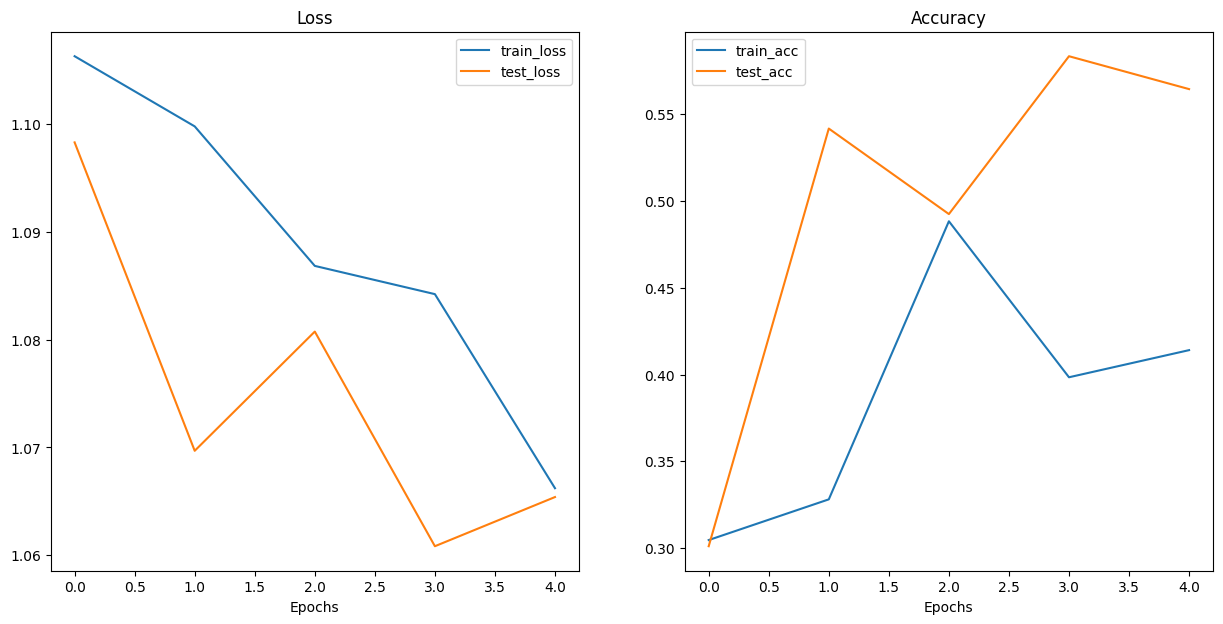

In [56]:
plot_loss_curve(model_0_results)

## 8. What should an ideal loss curve look like ?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic


## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling with this time using the same doel as before with some data augmentation

### 9.1 Create transform with data augmentation

In [57]:
# Create training transform with TrivialAugmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_simple = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])


### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [58]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transforms_simple)

In [59]:
# Turn your datasets into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 9.3 Construct and train model 1
This time we'll be using the same model architecture except this time we've augmented the training data

In [60]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [61]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

# Start the timer
start_time = timer()

# Train model 1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End the timer and show how long did it take to execute
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.105 | Train acc: 25.00% | Test loss: 1.102 | Test acc: 26.04%
Epoch: 1 | Train loss: 1.081 | Train acc: 42.58% | Test loss: 1.126 | Test acc: 26.04%
Epoch: 2 | Train loss: 1.071 | Train acc: 42.58% | Test loss: 1.159 | Test acc: 26.04%
Epoch: 3 | Train loss: 1.125 | Train acc: 30.47% | Test loss: 1.158 | Test acc: 26.04%
Epoch: 4 | Train loss: 1.087 | Train acc: 42.58% | Test loss: 1.155 | Test acc: 33.33%
Total training time for model_1: 20.400 seconds


### 9.4 Plot the loss curves of model_1

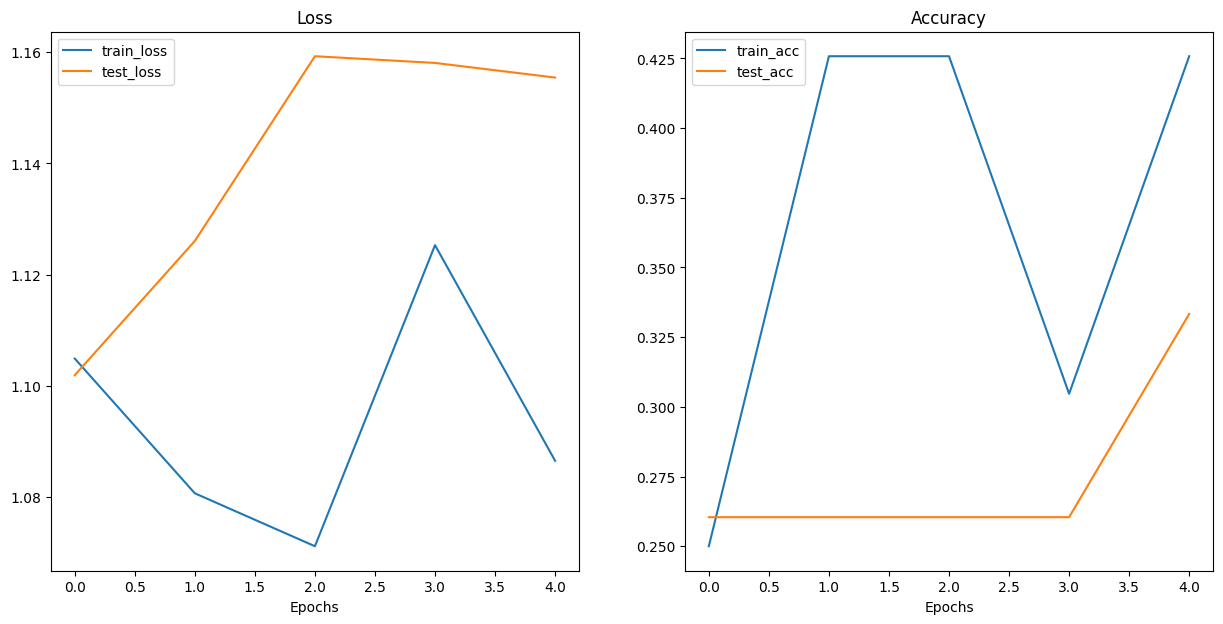

In [62]:
plot_loss_curve(model_1_results)

## 10. Compare model results
After evaluating our modelling experiment on their own, it's importnat to comare them to each other.

There's a few different ways to do this:
1. Hard coding
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [63]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


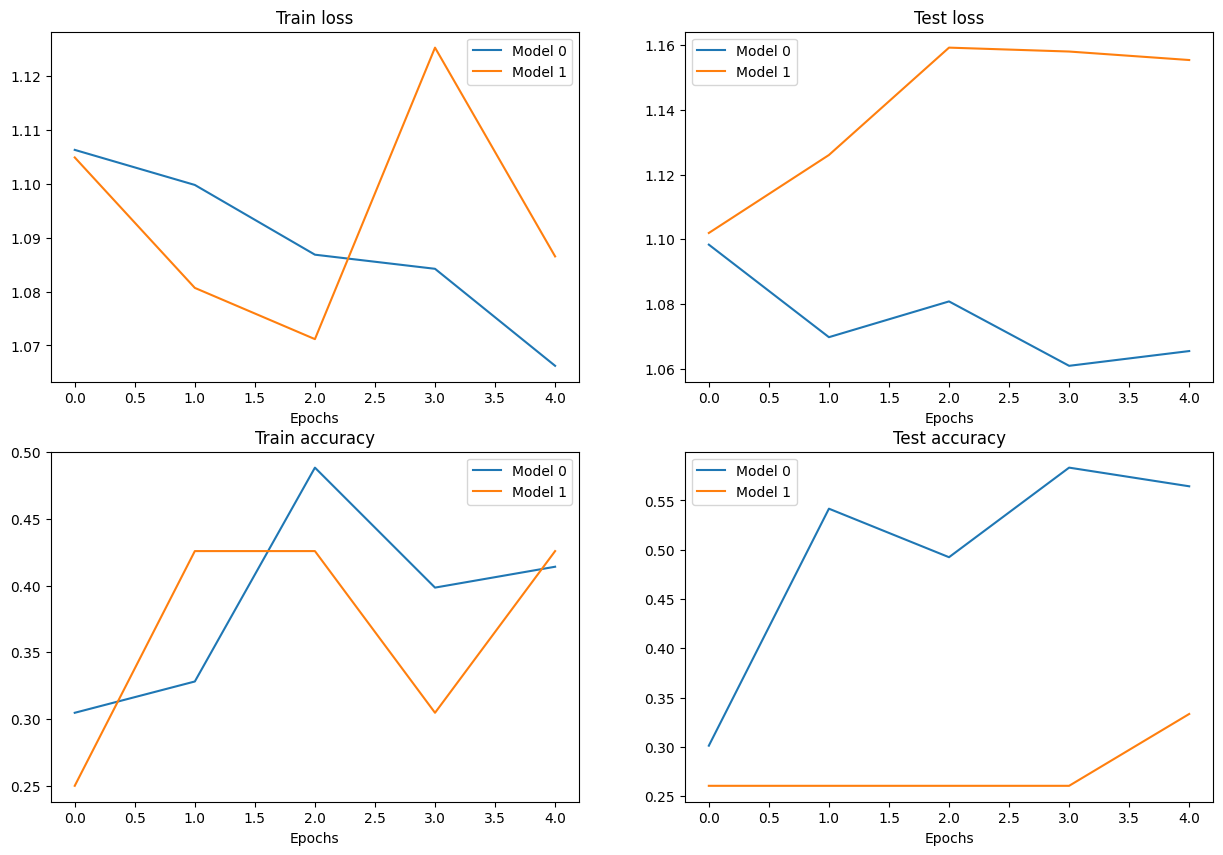

In [64]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image


In [65]:
# Dowload custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading rom GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exitst skipping download... ")

### 11.1 Loading in a custom image with PyTorch
We have to make our custom image is in the same format as the data our data our model was trained on.
- In tensor form with datatype (torch.float32)
- Of shape 64x64x3
- On the right device
We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [66]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [67]:
import torchvision

# Read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_unit8}")
print(f"Custom image shape: {custom_image_unit8.shape}")
print(f"Custom image datatype: {custom_image_unit8.dtype}")


Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

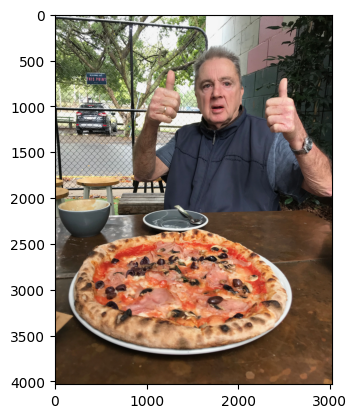

In [68]:
plt.imshow(custom_image_unit8.permute(1,2,0));

### 11.2 Making a prediciton ona  custom image with a trained PyTorch model

In [69]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [70]:
custom_image_transformer = transforms.Compose([
    transforms.Resize(size = (64,64))
])

custom_image_transformed = custom_image_transformer(custom_image)

print(f"Transformed Image shape: {custom_image_transformed.shape}")

Transformed Image shape: torch.Size([3, 64, 64])


In [72]:
# Adding the batch size and also making sure that it is on the right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred


tensor([[ 0.0781,  0.0379, -0.2067]])

Note, to make a prediciton on a custom image we had to:
- Load the image and turne it into a tensor
- Make sure the image was the same datatype as the model (torch.float32)
- Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size (1,3,64,64)
- Make sure the image was on the same device as our model

In [73]:
# Converting the logits -> prediction probabilites -> predicition label
custom_image_pred_label = class_names[torch.softmax(custom_image_pred,1).argmax(1)]
custom_image_pred_label

'pizza'

## 13. Putting custom image prediciton together: building a function

Ideal Outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [88]:
def custom_image_pred_plot(model: torch.nn.Module,
                           image_path: str):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
  transformer=transforms.Compose([
      transforms.Resize(size=(64,64))
  ])
  target_image = transformer(target_image).unsqueeze(0).to(device)

  # Getting the model prediction
  model.eval()
  with torch.inference_mode():
    pred_logits = model(target_image)
    pred_label = class_names[torch.softmax(pred_logits,1).argmax(1)]

  plt.imshow(target_image.squeeze().permute(1,2,0))
  plt.title(f"{pred_label}")
  plt.axis(False);


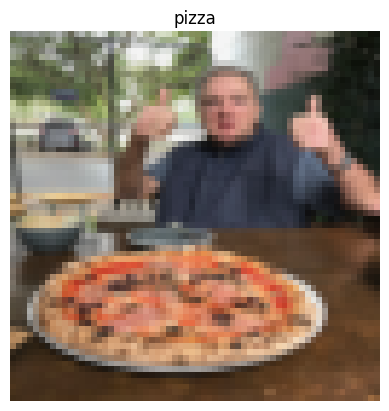

In [89]:
custom_image_pred_plot(model_1,custom_image_path)